In [1]:
import pickle
from scipy.sparse import csr_matrix
from clustering import visualize_silhouette_clusters, compare_true_labels
import numpy as np
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
from soyclustering import SphericalKMeans, visualize_pairwise_distance
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns


with open('data/mnist/minsupp_0.26/itemset_features.pkl', 'rb') as f:
    itemset_features = pickle.load(f)
    
with open('data/mnist_labels.pkl', 'rb') as f:
    true_labels = pickle.load(f)
    
print("num of groundtruth labels:", len(np.unique(true_labels)))

num of groundtruth labels: 10


In [2]:
#subsample because dataset is too big

subsample_indices = np.random.choice(len(itemset_features),5000,replace=False)
itemset_features = itemset_features[subsample_indices]
true_labels = true_labels[subsample_indices]

In [3]:
# adjust number of clusters
my_num_clusters = 10

# convert itemset_features to a sparse matrix that SphericalKMeans will accept
itemset_matrix = csr_matrix(itemset_features.astype(int))
density = itemset_matrix.getnnz() / np.prod(itemset_matrix.shape)
print("density of matrix:", density)

spherical_kmeans = SphericalKMeans(
        n_clusters=my_num_clusters,
        max_iter=100,
        verbose=0,
        init='similar_cut',
        #sparsity='minimum_df',
        minimum_df_factor=0.05
    )

results = []
i=0
while len(results)<10:
    try:
        sphkmeans_cluster_labels = spherical_kmeans.fit_predict(itemset_matrix)
        i+=1
        print('\nRun #' + str(i))
        result = compare_true_labels(true_labels, sphkmeans_cluster_labels, itemset_features)
        results.append(result)
    except Exception as e:
        # sometimes spherical clustering fails due to the initialization, re-run
        print(e)
        continue 

density of matrix: 0.3029493106244931

Run #1
Adjusted Rand Index: 0.24538204927616422
Normalized Mutual Information: 0.3555874465014824
Homogeneity: 0.353831254020919
Completeness: 0.3573611591779683
V-Measure: 0.35558744650148244
Silhouette Score: 0.09096726101899345

Run #2
Adjusted Rand Index: 0.24033608894529615
Normalized Mutual Information: 0.3574662783902048
Homogeneity: 0.3564494267143932
Completeness: 0.3584889482571626
V-Measure: 0.3574662783902047
Silhouette Score: 0.09046827175335011

Run #3
Adjusted Rand Index: 0.2563854694442523
Normalized Mutual Information: 0.36438603144673504
Homogeneity: 0.3624303598117322
Completeness: 0.36636292316552954
V-Measure: 0.364386031446735
Silhouette Score: 0.09583596139384751

Run #4
Adjusted Rand Index: 0.27020816304367734
Normalized Mutual Information: 0.3795163174423529
Homogeneity: 0.37783440401129925
Completeness: 0.38121327175634856
V-Measure: 0.3795163174423529
Silhouette Score: 0.09532656043765785

Run #5
Adjusted Rand Index: 0.2

In [4]:
results = np.array(results)
column_medians = np.median(results, axis=0)

print("Median values")
print("ARI: " + str(column_medians[0]))
print("NMI: " + str(column_medians[1]))
print("Homogeneity: " + str(column_medians[2]))
print("Completeness: " + str(column_medians[3]))
print("V-Measure: " + str(column_medians[4]))
print("Silhouette: " + str(column_medians[5]))

Median values
ARI: 0.24207041671999976
NMI: 0.3550893000961799
Homogeneity: 0.3538539942987545
Completeness: 0.35597337207969126
V-Measure: 0.35508930009618
Silhouette: 0.09159158804477086


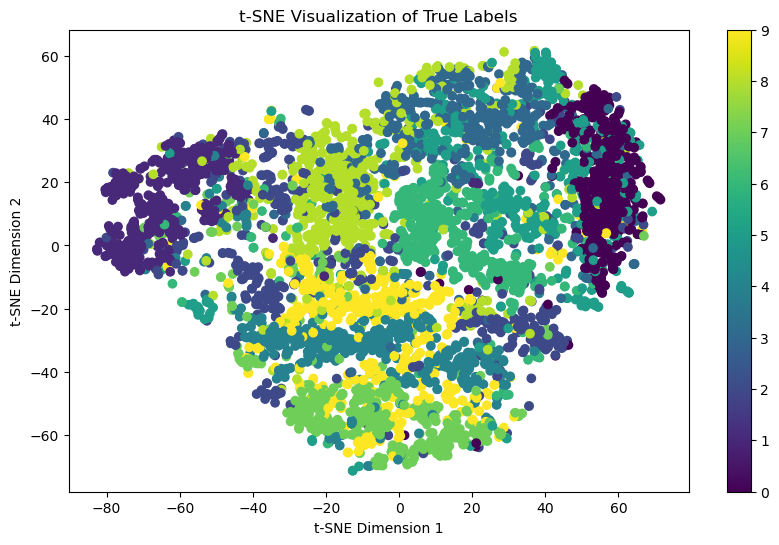

In [5]:
## using t-sne (alternative to pca) to visualize clusters according to true labels

# Calculate cosine distances between binary vectors
cosine_distances_matrix = cosine_distances(itemset_features)

# Create a t-SNE instance with cosine distance
tsne = TSNE(n_components=2, metric="precomputed", perplexity=30, learning_rate=200, init="random")

# Fit t-SNE to the cosine distance matrix
tsne_results = tsne.fit_transform(cosine_distances_matrix)

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))


plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=true_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of True Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


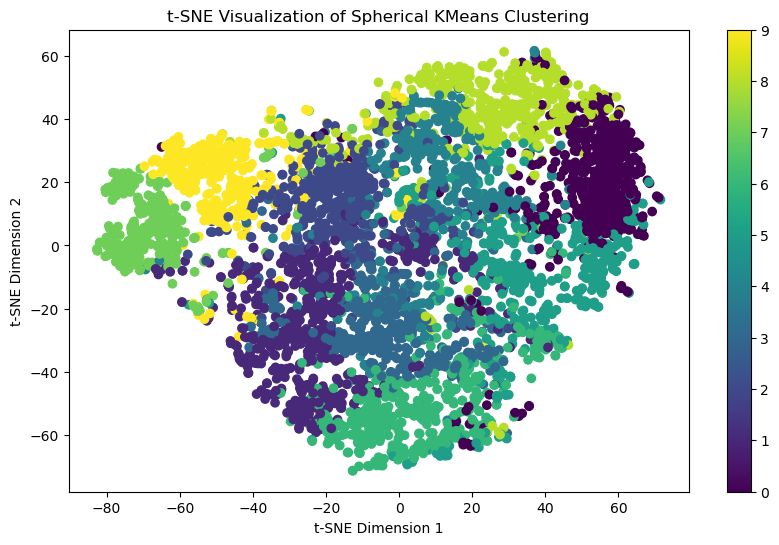

In [6]:
## using t-sne (alternative to pca) to visualize Spherical KMeans clusters

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=sphkmeans_cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Spherical KMeans Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


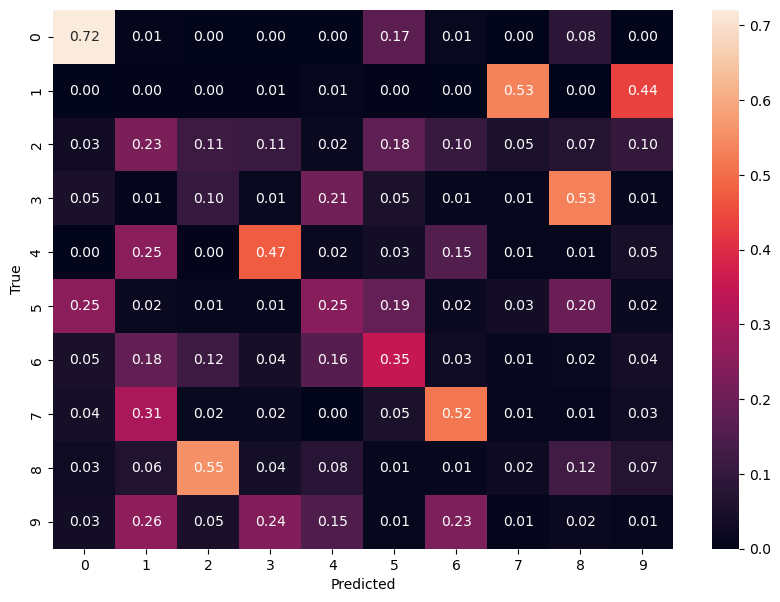

In [7]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, sphkmeans_cluster_labels, normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".2f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

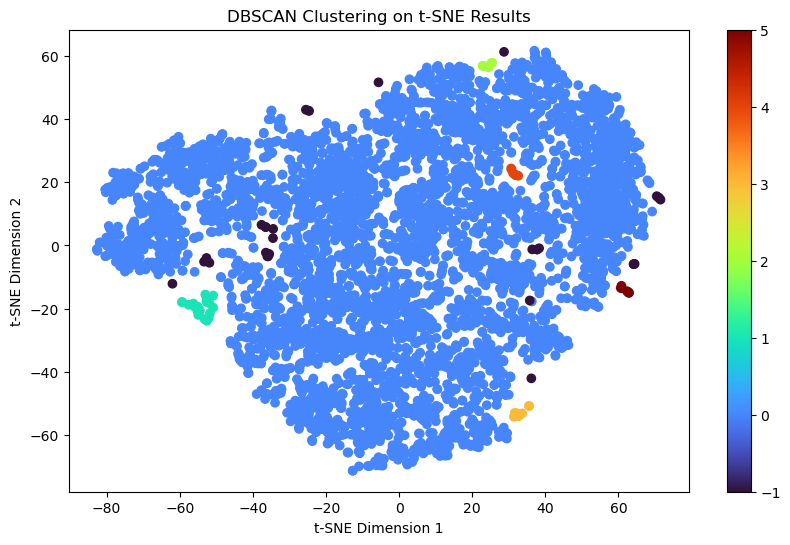

Adjusted Rand Index: 0.0003524017353950914
Normalized Mutual Information: 0.016377139815251258
Homogeneity: 0.17277300744820578
Completeness: 0.008595975845477678
V-Measure: 0.01637713981525126
Silhouette Score: 0.03561464023214782


array([0.0003524 , 0.01637714, 0.17277301, 0.00859598, 0.01637714,
       0.03561464])

In [8]:
## performing DBSCAN on the data transformed by t-sne

from sklearn.cluster import DBSCAN

# Apply DBSCAN to the t-SNE results
dbscan = DBSCAN(eps=3.4, min_samples=5)
dbscan_labels = dbscan.fit_predict(tsne_results)

# Create a scatter plot to visualize the DBSCAN clustering results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dbscan_labels, cmap='turbo')
plt.colorbar()
plt.title('DBSCAN Clustering on t-SNE Results')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

compare_true_labels(dbscan_labels, true_labels, itemset_features)

In [9]:
## REMOVE OUTLIERS IDEA

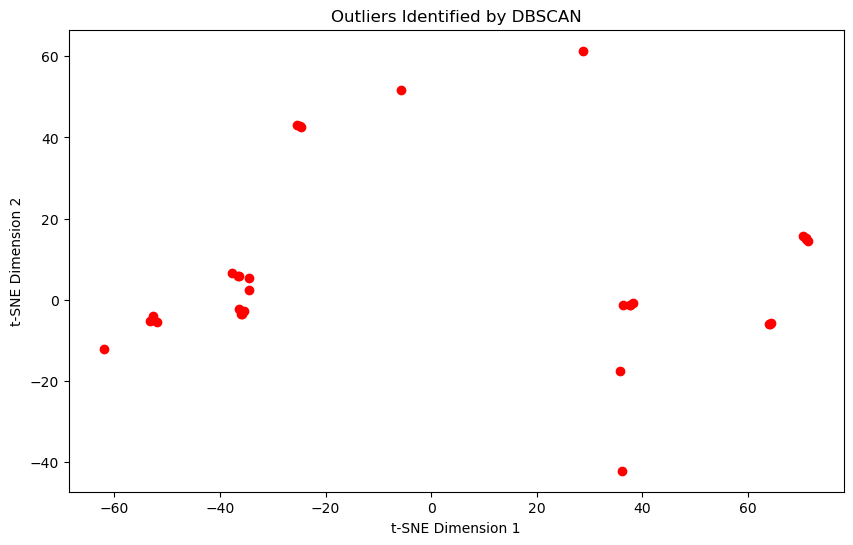

In [10]:
# Filter out the outlier points
outlier_points = tsne_results[dbscan_labels == -1]

# Create a scatter plot for the outliers
plt.figure(figsize=(10, 6))
plt.scatter(outlier_points[:, 0], outlier_points[:, 1], color='red')
plt.title('Outliers Identified by DBSCAN')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [11]:
outlier_index = np.where(dbscan_labels==-1)

filtered_data = np.delete(itemset_features, outlier_index, axis=0)
filtered_labels = np.delete(true_labels, outlier_index, axis=0)
print(len(filtered_labels), len(true_labels))

# convert itemset_features to a sparse matrix that SphericalKMeans will accept
filtered_itemset_matrix = csr_matrix(filtered_data.astype(int))

spherical_kmeans = SphericalKMeans(
        n_clusters=11,
        max_iter=100,
        verbose=0,
        init='similar_cut',
        #sparsity='minimum_df',
        minimum_df_factor=0.05
    )

results = []
i = 0

while len(results)<10:
    try:
        filtered_sphkmeans_cluster_labels = spherical_kmeans.fit_predict(filtered_itemset_matrix)
        i+=1
        print('\nRun #' + str(i))
        result = compare_true_labels(filtered_labels, filtered_sphkmeans_cluster_labels, filtered_data)
        results.append(result)
    except Exception as e:
        # sometimes spherical clustering fails due to the initialization, re-run
        print(e)
        continue 

4968 5000

Run #1
Adjusted Rand Index: 0.2418418329766133
Normalized Mutual Information: 0.36815858716270183
Homogeneity: 0.37422977226416415
Completeness: 0.36228124479459234
V-Measure: 0.36815858716270183
Silhouette Score: 0.09175959270374641

Run #2
Adjusted Rand Index: 0.2154120930137555
Normalized Mutual Information: 0.346985057155463
Homogeneity: 0.3511649385995158
Completeness: 0.34290351066889857
V-Measure: 0.346985057155463
Silhouette Score: 0.0923812140881473

Run #3
Adjusted Rand Index: 0.2282909915514773
Normalized Mutual Information: 0.3519996840900099
Homogeneity: 0.35862316287295853
Completeness: 0.34561642912398277
V-Measure: 0.3519996840900099
Silhouette Score: 0.09026743818910511

Run #4
Adjusted Rand Index: 0.23089134826612456
Normalized Mutual Information: 0.3549153894409169
Homogeneity: 0.3613720987140139
Completeness: 0.34868535678331086
V-Measure: 0.35491538944091694
Silhouette Score: 0.09074488135047545

Run #5
Adjusted Rand Index: 0.19732848856381383
Normalized

In [12]:
results = np.array(results)
column_medians = np.median(results, axis=0)

print("Median values")
print("ARI: " + str(column_medians[0]))
print("NMI: " + str(column_medians[1]))
print("Homogeneity: " + str(column_medians[2]))
print("Completeness: " + str(column_medians[3]))
print("V-Measure: " + str(column_medians[4]))
print("Silhouette: " + str(column_medians[5]))

Median values
ARI: 0.23311557229830182
NMI: 0.3554249676576979
Homogeneity: 0.36195387677076074
Completeness: 0.3491274415547382
V-Measure: 0.3554249676576979
Silhouette: 0.09207040339594685


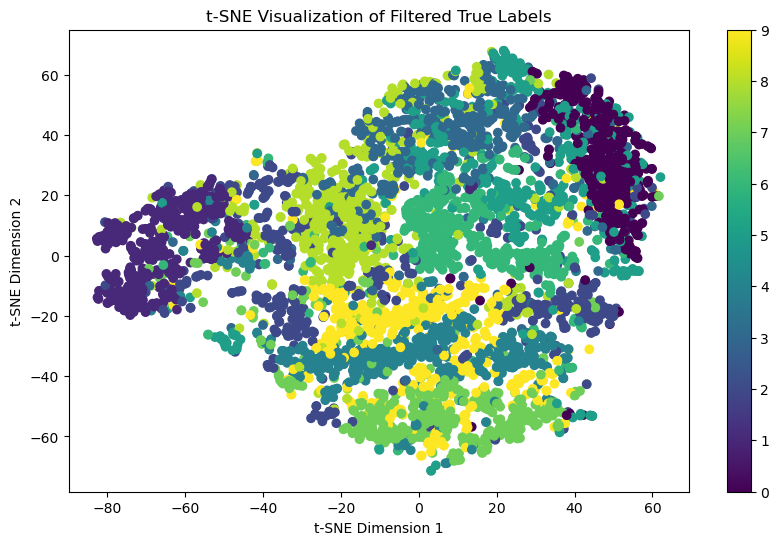

In [13]:
## using t-sne (alternative to pca) to visualize filtered true clusters

# Calculate cosine distances between binary vectors
cosine_distances_matrix = cosine_distances(filtered_data)

# Create a t-SNE instance with cosine distance
tsne = TSNE(n_components=2, metric="precomputed", perplexity=30, learning_rate=200, init="random")

# Fit t-SNE to the cosine distance matrix
tsne_results = tsne.fit_transform(cosine_distances_matrix)

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))


plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Filtered True Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


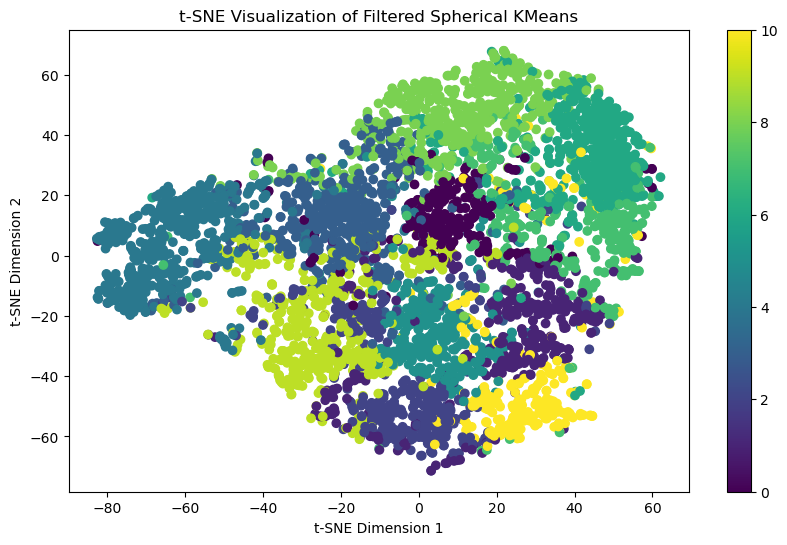

In [14]:
## using t-sne (alternative to pca) to visualize filtered SPHKMEANS clusters

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_sphkmeans_cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Filtered Spherical KMeans')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


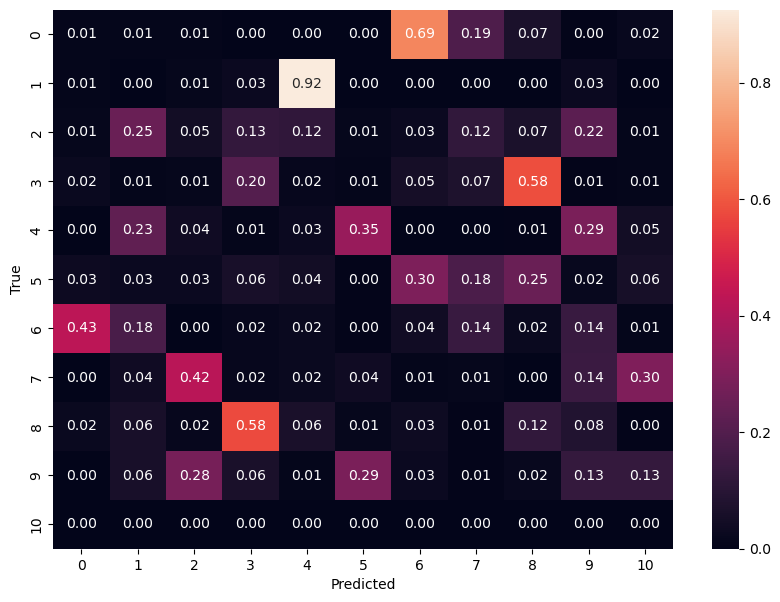

In [15]:
# Calculate the confusion matrix
cm = confusion_matrix(filtered_labels, filtered_sphkmeans_cluster_labels, normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".2f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()